<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=174859880" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install faiss-gpu pytorch-metric-learning
from fastai.vision.all import *
import logging
import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        embeddings = self.get_embedding(x)
        classifications = self.head(embeddings)
        return embeddings.view(embeddings.shape[0], -1), classifications

    def get_embedding(self, x):
        x = self.encoder(x)
        return x

backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(backbone.classifier[-1].in_features, 37, [1024, 512], 0.5, bn_final=True)
apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

In [3]:
#model

In [4]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers,regularizers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from collections import defaultdict
import random

def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, min(50, len(files))))
    return sampled_files

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files_sample, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
loaders = pets.dataloaders("/kaggle/input/the-oxfordiiit-pet-dataset/images")

In [5]:
#len(loaders.vocab)

In [6]:
#loaders.train.show_batch(max_n=6, nrows=2)

In [7]:
#loaders.valid.show_batch(max_n=6, nrows=2)

In [8]:
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0.2,high=1.8)
loss_func = losses.TripletMarginLoss(margin=1, distance=distance, reducer=reducer)
mining_func = miners.MultiSimilarityMiner()
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, with_embed=True):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.with_embed = with_embed
    def forward(self, preds, target):
        embeddings, classifications = preds
        embed_loss = self.embed_loss_func(embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.with_embed:
            return embed_loss + class_loss
        else:
            return class_loss

combined_loss = CombinedLoss(my_loss, classification_loss, with_embed=False)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,3.688155,2.956495,0.240541,0.412389,0.349296,0.197561,00:15
1,3.208000,1.776326,0.667568,0.693498,0.683519,0.572237,00:13
2,2.710625,1.098180,0.791892,0.803369,0.790014,0.693299,00:13
3,2.259909,0.796809,0.854054,0.855983,0.845290,0.780991,00:13
4,1.906263,0.669362,0.862162,0.860172,0.855672,0.786418,00:13
5,1.622552,0.604401,0.870270,0.864013,0.857172,0.792819,00:12
6,1.419986,0.554231,0.889189,0.881949,0.875729,0.814226,00:13
7,1.255039,0.523043,0.900000,0.893251,0.889722,0.838564,00:13
8,1.122667,0.502117,0.889189,0.878955,0.880770,0.819508,00:13
9,1.003508,0.460664,0.905405,0.897556,0.899069,0.848024,00:13


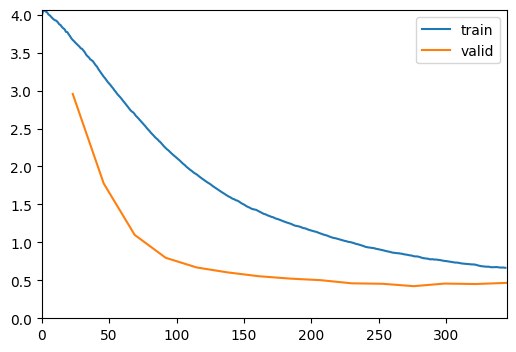

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.541946,0.431726,0.910811,0.898412,0.908257,0.857115,00:15
1,0.524235,0.414627,0.918919,0.909179,0.913523,0.868301,00:16
2,0.501259,0.409770,0.921622,0.909776,0.918258,0.875124,00:16
3,0.502229,0.405798,0.913514,0.912531,0.917852,0.869501,00:16
4,0.489474,0.365546,0.918919,0.910794,0.916774,0.874696,00:16
5,0.474811,0.362394,0.918919,0.913955,0.916868,0.877758,00:16
6,0.452138,0.370455,0.924324,0.922270,0.924417,0.889128,00:15
7,0.445401,0.345925,0.924324,0.924888,0.927994,0.885591,00:16
8,0.431403,0.342392,0.935135,0.935367,0.933331,0.897414,00:16
9,0.390573,0.339773,0.932432,0.933620,0.932021,0.895617,00:16


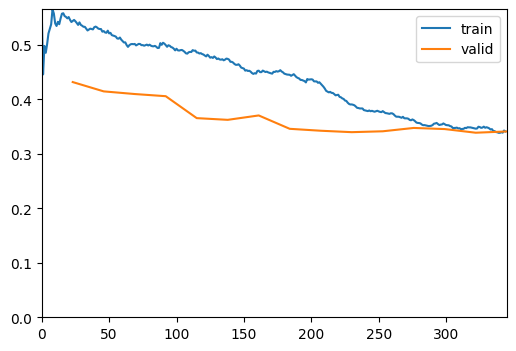

In [10]:
learn.fine_tune(15,freeze_epochs=15)

In [11]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

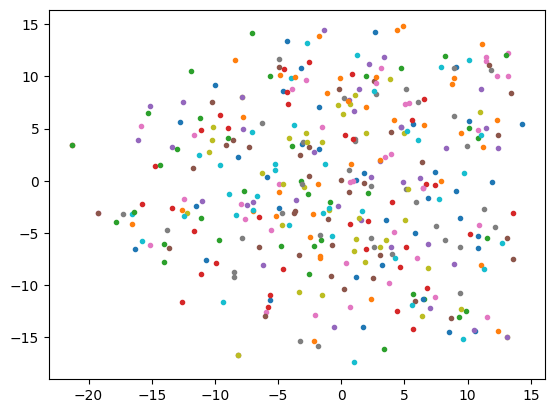

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

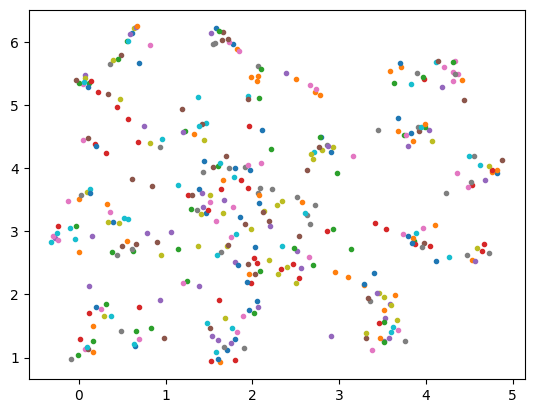

In [13]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')